# Behavioral Cloning 

This notebook is used for development. Final model and processing will be within model.py. 

# Part 1: Data Processing 

### Importing Packages:

In [1]:
import os 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 

import cv2
import math

from scipy import signal
import sklearn
import csv

print('Pacakages Imported')

Pacakages Imported


## Loading Data:

Because of how large the data file is for the training data, I have the data saved outside of this workspace. 

In [2]:
# Set CSV Path
csv_path = '../udacity-track1-data/driving_log.csv'

# Read Data from CSV File
data_full = pd.read_csv(csv_path, 
                        index_col = False)
data_full['direction'] = pd.Series('s', index=data_full.index)

# Column Labels: ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']

print('Sucessfully accessed csv file')

Sucessfully accessed csv file


In [3]:
## Print out information:
num_frames = data_full.shape[0]

print('Number of Image Frames (Left, Center, Right Images):', num_frames)


Number of Image Frames (Left, Center, Right Images): 8036


## Plot Steering, Throttle, Break, and Speed vs. Time

In [4]:
def plotData(data_plot, plot_len, ax1, ax2, y_min, y_max, title, width, height):
    
    if plot_len == None:
        plot_len = len(data_plot)
    
    t = np.arange(len(data_plot))
    x = data_plot

    fig = plt.figure(figsize=(width, height))

    plt.plot(t[0:plot_len],x[0:plot_len]);
    plt.xlabel(ax1)
    plt.ylabel(ax2)
    plt.title(title)
    plt.ylim(y_min,y_max)

    return fig

### Steering vs. Time

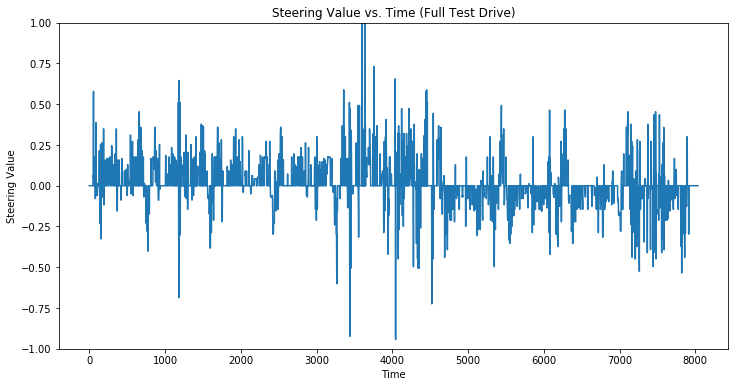

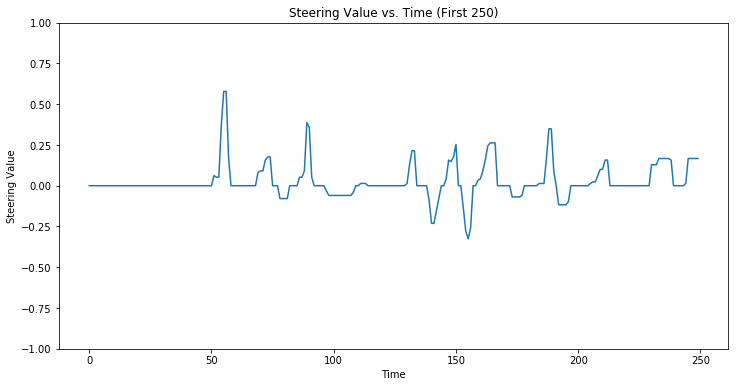

In [5]:
## Steering Range: -1 to 1

# Was accidentally including the first row with strings if header was set to false when loading the csv data
#print(type(data_full.steering))
#print(data_full.steering)

data_steer = np.array(data_full.steering,dtype=np.float32)

data_plot = data_steer
ax1 = "Time"
ax2 = "Steering Value"
y_min, y_max = -1, 1
title = "Steering Value vs. Time (Full Test Drive)"
width, height = 12, 6

# plot full range: 
fig1 = plotData(data_plot, None, ax1, ax2, y_min, y_max, title, width, height)

# plot small range:
plot_len = 250
title = "Steering Value vs. Time (First 250)"
fig2 = plotData(data_plot, plot_len, ax1, ax2, y_min, y_max, title, width, height)

## Save Images 
save_on = False

if save_on:
    fig1.savefig('./notebook_images/steering_vs_time_full.png') # save the figure to file
    fig2.savefig('./notebook_images/steering_vs_time_partial.png') # save the figure to file

### Throttle vs. Time

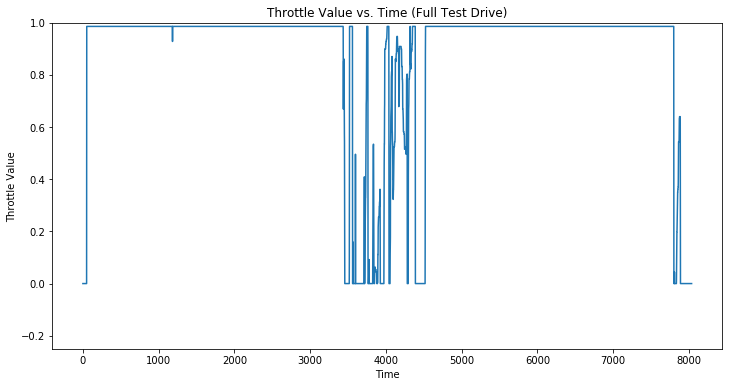

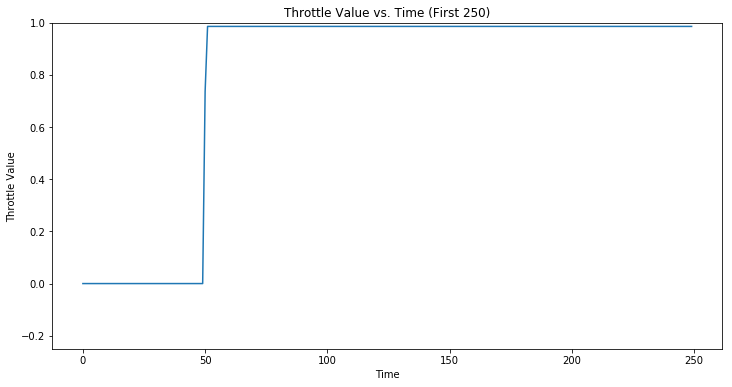

In [6]:
## Throttle Range: 0 to 1

data_throttle = np.array(data_full.throttle,dtype=np.float32)

data_plot = data_throttle
ax1 = "Time"
ax2 = "Throttle Value"
y_min, y_max = -0.25, 1
title = "Throttle Value vs. Time (Full Test Drive)"
width, height = 12, 6

# plot full range: 
fig1 = plotData(data_plot, None, ax1, ax2, y_min, y_max, title, width, height)

# plot small range:
plot_len = 250
title = "Throttle Value vs. Time (First 250)"
fig2 = plotData(data_plot, plot_len, ax1, ax2, y_min, y_max, title, width, height)

## Save Images 
save_on = False 

if save_on:
    fig1.savefig('./notebook_images/throttle_vs_time_full.png') # save the figure to file
    fig2.savefig('./notebook_images/throttle_vs_time_partial.png') # save the figure to file

### Brake vs. Time

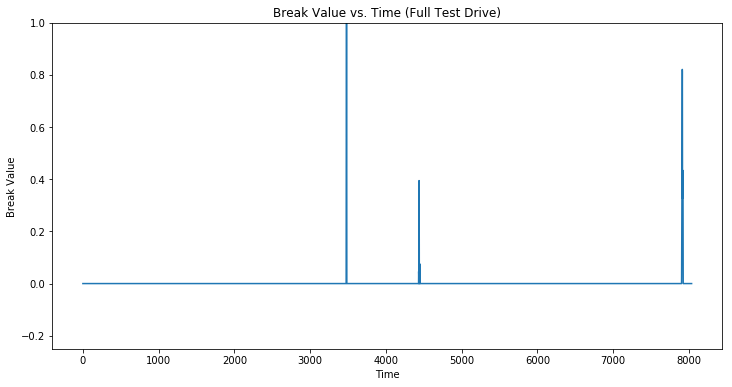

In [7]:
## Brake Range: 0 to 1

data_brake = np.array(data_full.brake,dtype=np.float32)

data_plot = data_brake
ax1 = "Time"
ax2 = "Break Value"
y_min, y_max = -0.25, 1
title = "Break Value vs. Time (Full Test Drive)"
width, height = 12, 6

# plot full range: 
fig1 = plotData(data_plot, None, ax1, ax2, y_min, y_max, title, width, height)

## Save Images 
save_on = False

if save_on:
    fig1.savefig('./notebook_images/break_vs_time_full.png') # save the figure to file

### Speed vs. Time

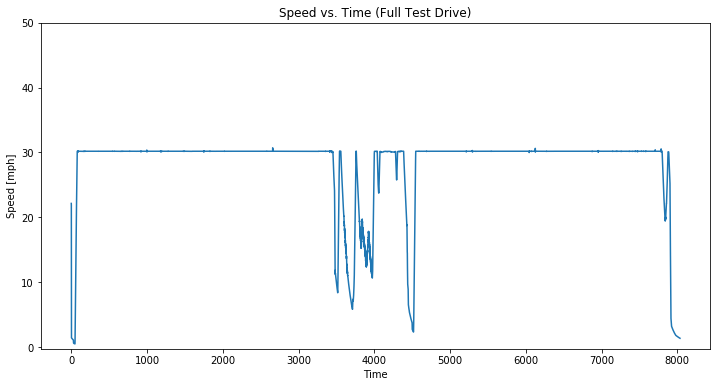

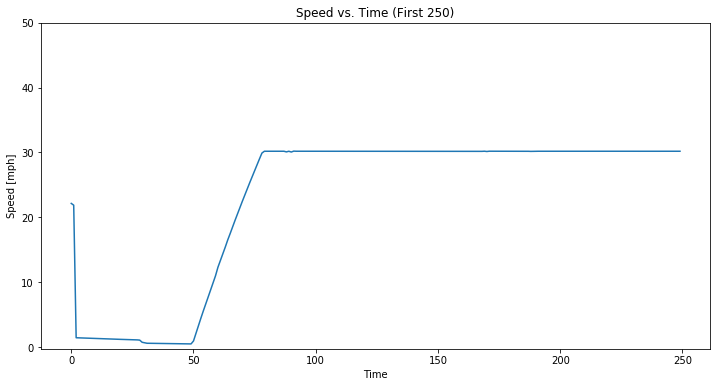

In [8]:
## Speed Range: 0 to 30
data_speed = np.array(data_full.speed,dtype=np.float32)

data_plot = data_speed
ax1 = "Time"
ax2 = "Speed [mph]"
y_min, y_max = -0.25, 50
title = "Speed vs. Time (Full Test Drive)"
width, height = 12, 6

# plot full range: 
fig1 = plotData(data_plot, None, ax1, ax2, y_min, y_max, title, width, height)

# plot small range:
plot_len = 250
title = "Speed vs. Time (First 250)"
fig2 = plotData(data_plot, plot_len, ax1, ax2, y_min, y_max, title, width, height)

## Save Images 
save_on = False  

if save_on:
    fig1.savefig('./notebook_images/speed_vs_time_full.png') # save the figure to file
    fig2.savefig('./notebook_images/speed_vs_time_partial.png') # save the figure to file

Because I will only be training for steering angle, I care most about that. Still, from these plots, I can see that the essentially the break was never used, speed is at a maximum until around midway through, which is probably during sections of the track where there is heavy turning. The throttle value also corroborates with the speed value.

## Showing Random Images:

Before I do any data processing, I will show some random frames just for a reference. 

In [9]:
# Define a image function loading the input image. 
# *Note, will not normalize the image input until put image through pipeline. No point in doing it until then. 
def getImg(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

# This function adds to the path in the csv file so you can actually access an image. 
def getPath(local_path):
    filename = local_path.split("/")[-1]
    host_path = '../udacity-track1-data/IMG/'+filename               # CHANGE HOST PATH SUBSTRING 1 AS NEEDED 
    # print(host_path) 
    return host_path

In [19]:
import random 

# Plot 3 random frames: Center, Left, and Right Images
# Problem with plotting with N > 1, so just do 1
def plot_rand_frames(data, width, height):
    
    data_steer = np.array(data.steering,dtype=np.float32)
    #data_steer = data.steering
    
    fig = plt.figure(figsize=(width,height))
    
    n_frames = data.shape[0]
    rand_img_num = random.randint(0,n_frames-1)
    print('Showing Image Number', rand_img_num)
        
    # extract random frame images
    img_center = getImg(getPath(data['center'][rand_img_num].strip()))
    img_left = getImg(getPath(data['left'][rand_img_num].strip()))
    img_right = getImg(getPath(data['right'][rand_img_num].strip()))
        
    # Plot Left 
    plt.subplot(1,3,1)
    plt.imshow(img_left) 
    plt.text(10,25,'Left', color='k',backgroundcolor='c')
    plt.title('Image Frame Number ' + str(rand_img_num))
    plt.axis('off')
        
    # Plot Center 
    plt.subplot(1,3,2)
    plt.imshow(img_center) 
    plt.text(10,25,'Center', color='k',backgroundcolor='c')
    plt.title('Steering Angle: ' + str(data_steer[rand_img_num]))
    plt.axis('off')
        
    # Plot Left 
    plt.subplot(1,3,3)
    plt.imshow(img_right) 
    plt.text(10,25,'Right', color='k',backgroundcolor='c')
    plt.axis('off')
        
    return fig

Showing Image Number 359
Confirmed: image pulling from folder
Proceed


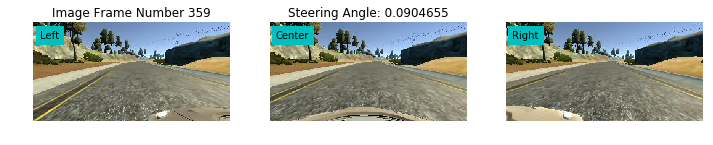

In [29]:
## Plot Random Spread of Images

width, height = 12, 2
fig = plot_rand_frames(data_full, width, height)

## Save Images 
save_on = False

if save_on:
    fig.savefig('./notebook_images/random_1by3_imgs.png') # save the figure to file
    
print('Confirmed: image pulling from folder')
print('Proceed')

## Data Processing (and Augmentations)

### 1: Adding Left and Right Images to Data Stack

The advantage of adding Left and Right images is that I can triple the number of images. But, I am only training my network to view center camera images so I need to essentially transform the left and right images from a frame to 'become' a center image. I do this by adding a steering angle correction to the vehicle which suggests that the car needs to correct itself because its centered on the left or right e.g. right images: steering -= correction; left images: steering += correction. The addtional advantage of this is that this serves as recovery data in a way. 

I started with 0.2 (as suggested by udacity tutorial) and increased the value at increments of one. I found 0.25 to work the best (best training + validation loss), but I only tried 7 values. More expiramentation could yield a better result. 

In [30]:
def pull_rand_frame(data):
    n_frames = data.shape[0]
    rand_img_num = random.randint(0,n_frames-1)
    
    #print('Showing Image Number', rand_img_num)
        
    # extract random frame images
    img_center = getImg(getPath(data['center'][rand_img_num].strip()))
    img_left = getImg(getPath(data['left'][rand_img_num].strip()))
    img_right = getImg(getPath(data['right'][rand_img_num].strip()))

    return rand_img_num, img_left, img_center, img_right

In [31]:
def pull_LCR_frame(data,frame):
    
    # extract random frame images
    img_center = getImg(getPath(data['center'][rand_img_num].strip()))
    img_left = getImg(getPath(data['left'][rand_img_num].strip()))
    img_right = getImg(getPath(data['right'][rand_img_num].strip()))
    
    return img_left, img_center, img_right

In [43]:
## Test Getting Random 3 and adding to the stack. 

def test_LCR_and_steering_mod(data, hieght, width):

    frame, img_left, img_center, img_right = pull_rand_frame(data)
    
    fig = plt.figure(figsize=(width,height))
    fig.suptitle("Frame Number: " + str(frame))
    
    steering_C= data.steering[frame]

    ## Left Image 
    steering_L= steering_C + 0.25
    plt.subplot(1,3,1)
    plt.imshow(img_left) 
    plt.text(10,25,'Left', color='k',backgroundcolor='c')
    plt.title('Steering Value: ' + str(steering_L))
    plt.axis('off')
    
    ## Center Image 
    plt.subplot(1,3,2)
    plt.imshow(img_center)
    plt.text(10,25,'Center', color='k',backgroundcolor='c')
    plt.title('Steering Value: ' + str(steering_C))
    plt.axis('off')
    
    ## Right Image
    steering_R = steering_C - 0.25
    plt.subplot(1,3,3)
    plt.imshow(img_right) 
    plt.text(10,25,'Right', color='k',backgroundcolor='c')
    plt.title('Steering Value: ' + str(steering_R))
    plt.axis('off')

    return fig

Confirmed: augmenting steering values for Left and Right Images
Proceed


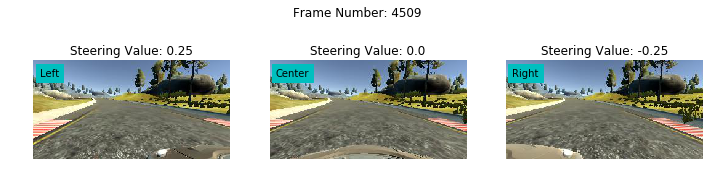

In [44]:
width, height = 12, 3
fig = test_LCR_and_steering_mod(data_full, hieght, width)

## Save Images 
save_on = False

if save_on:
    fig.savefig('./notebook_images/random_LCR_steering_corrected.png') # save the figure to file
    
print('Confirmed: augmenting steering values for Left and Right Images')
print('Proceed')

### 2: Brightness Augmentation

Augment brightness to eliminate lighting as factor for impacting decisions in neural net. Will not be using CLAHE as well or any other histogram equalization because this neural net only takes in images from a simulation, so the detriment of brighness will not be great. 

To do this, I convert to HSV and then scale Saturation between 0.25 and 1.25. I then convert the image back to RGB